In [1]:
from pathlib import Path
import colokroll as cr
import logging

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

In [2]:
# Uplaod your image
image_path = Path("/fs/scratch/PAS2598/duarte63/ALIX_confocal_data/ALIX/nd2/anti_ALIX_ctrl_3.ome.tiff")

loader = cr.ImageLoader(auto_convert=False)
image = loader.load_image(image_path)
channel_names = loader.get_channel_names()

INFO: Found 1 Channel elements but SizeC is 4. Adding default names.
INFO: Extracted metadata from OME-XML: pixel_size=0.108333333333333μm, channels=4
INFO: Squeezed singleton dim(s): (25, 1800, 1800, 4, 1) -> (25, 1800, 1800, 4)
INFO: Successfully loaded TIFF image with shape: (25, 1800, 1800, 4)


In [3]:
#Rename the channels

new_channel_names = ['LAMP1', 'Phalloidin', 'ALIX', 'DAPI']
loader.rename_channels(new_channel_names)
channel_names = loader.get_channel_names()

INFO: Renamed channels to: ['LAMP1', 'Phalloidin', 'ALIX', 'DAPI']


In [4]:
import time
import cupy as cp

bg_subtractor = cr.BackgroundSubtractor()

results = {}

for i, ch in enumerate(channel_names):
    ch_data = image[:, :, :, i]
    t0 = time.perf_counter()
    corrected, meta = bg_subtractor.subtract_background(
        image=ch_data,
        channel_name=ch,
        # method omitted -> auto search + full run
    )
    cp.cuda.Stream.null.synchronize()
    dt = time.perf_counter() - t0

    results[ch] = (corrected, meta)

INFO: Initializing CUDA-accelerated background subtractor
INFO: GPU Memory: 39.1GB free / 39.5GB total
INFO: Running AUTO background subtraction (channel=LAMP1)
INFO: CUDA gaussian (channel=LAMP1, sigma=275.0, z=9)
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=275.0
INFO: CUDA gaussian (channel=LAMP1, sigma=275.0, z=25)
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=275.0
INFO: Running AUTO background subtraction (channel=Phalloidin)
INFO: CUDA rolling_ball (channel=Phalloidin, radius=144, z=9)
INFO: Processing 9 z-slices with CUDA rolling ball approximation (radius=144)
INFO: CUDA rolling_ball (channel=Phalloidin, radius=144, z=25)
INFO: Processing 25 z-slices with CUDA rolling ball approximation (radius=144)
INFO: Running AUTO background subtraction (channel=ALIX)
INFO: CUDA gaussian (channel=ALIX, sigma=275.0, z=9)
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=275.0
INFO: CUDA gaussian (channel=ALIX, sigma=275.0, z=25)
INFO:

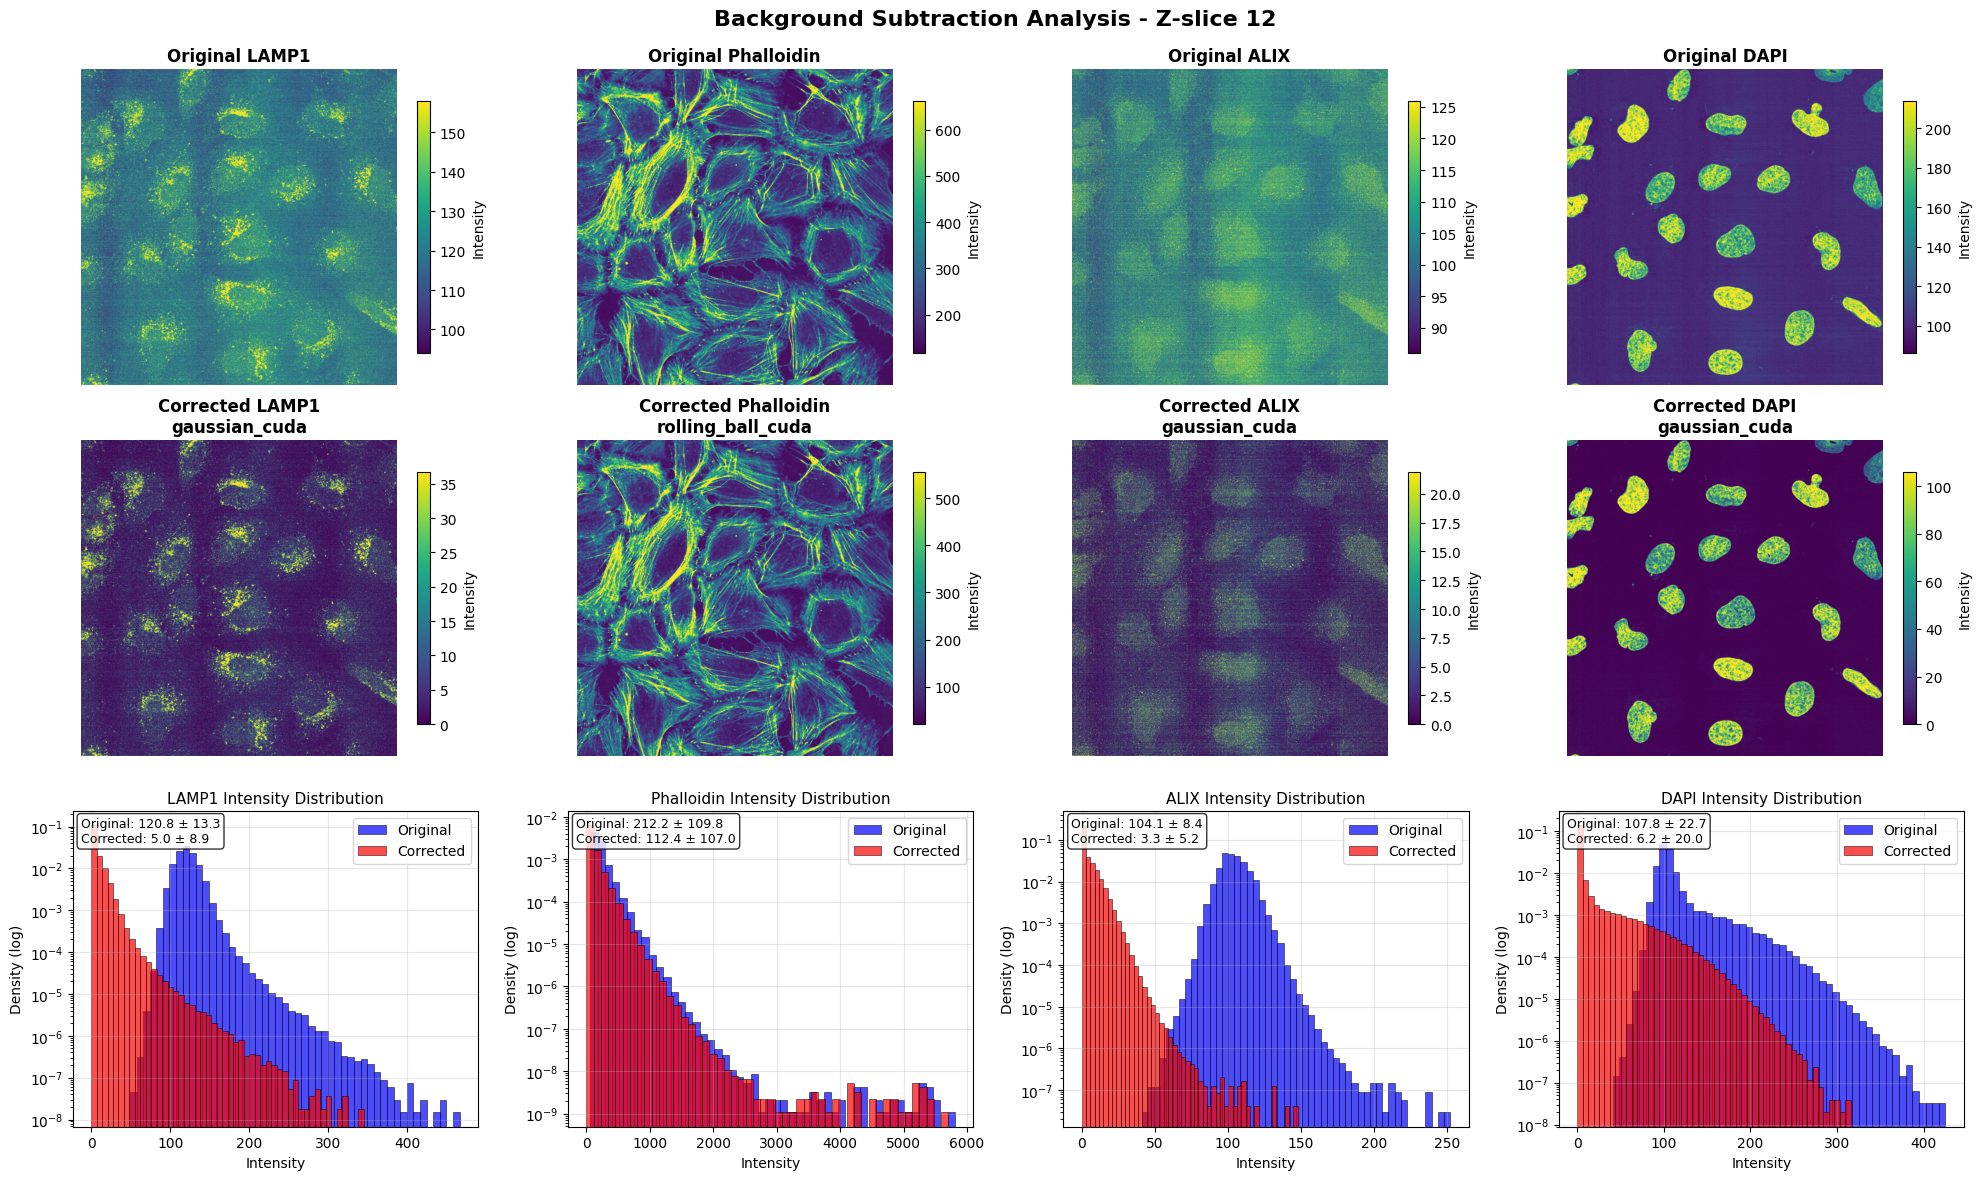

In [5]:
#visualize the effect of background removal.

middle_slice_idx = image.shape[0]//2


fig = bg_subtractor.plot_background_subtraction_comparison(
    original_data=image,
    corrected_results=results,
    channel_names=channel_names,
    z_slice=middle_slice_idx,
    figsize=(5*len(channel_names), 12)
)

INFO: Comparing 6 strategies...
INFO:   [1/6] Running: FFT + Closest (Auto 0.8)
INFO:     Kept 16 / 25 slices
INFO:   [2/6] Running: FFT + Closest (Auto 0.7)
INFO:     Kept 20 / 25 slices
INFO:   [3/6] Running: FFT + Closest (k=14)
INFO:     Kept 14 / 25 slices
INFO:   [4/6] Running: Combined + Closest (Auto)
INFO:     Kept 3 / 25 slices
INFO:   [5/6] Running: FFT + TopK (k=20)
INFO:     Kept 20 / 25 slices
INFO:   [6/6] Running: FFT + Relative (0.6)
INFO:     Kept 0 / 25 slices
INFO: Generating comparison visualizations in strategy_qc...


  - Creating decision matrix heatmap...
    ✓ Saved: strategy_qc/decision_matrix_heatmap.png


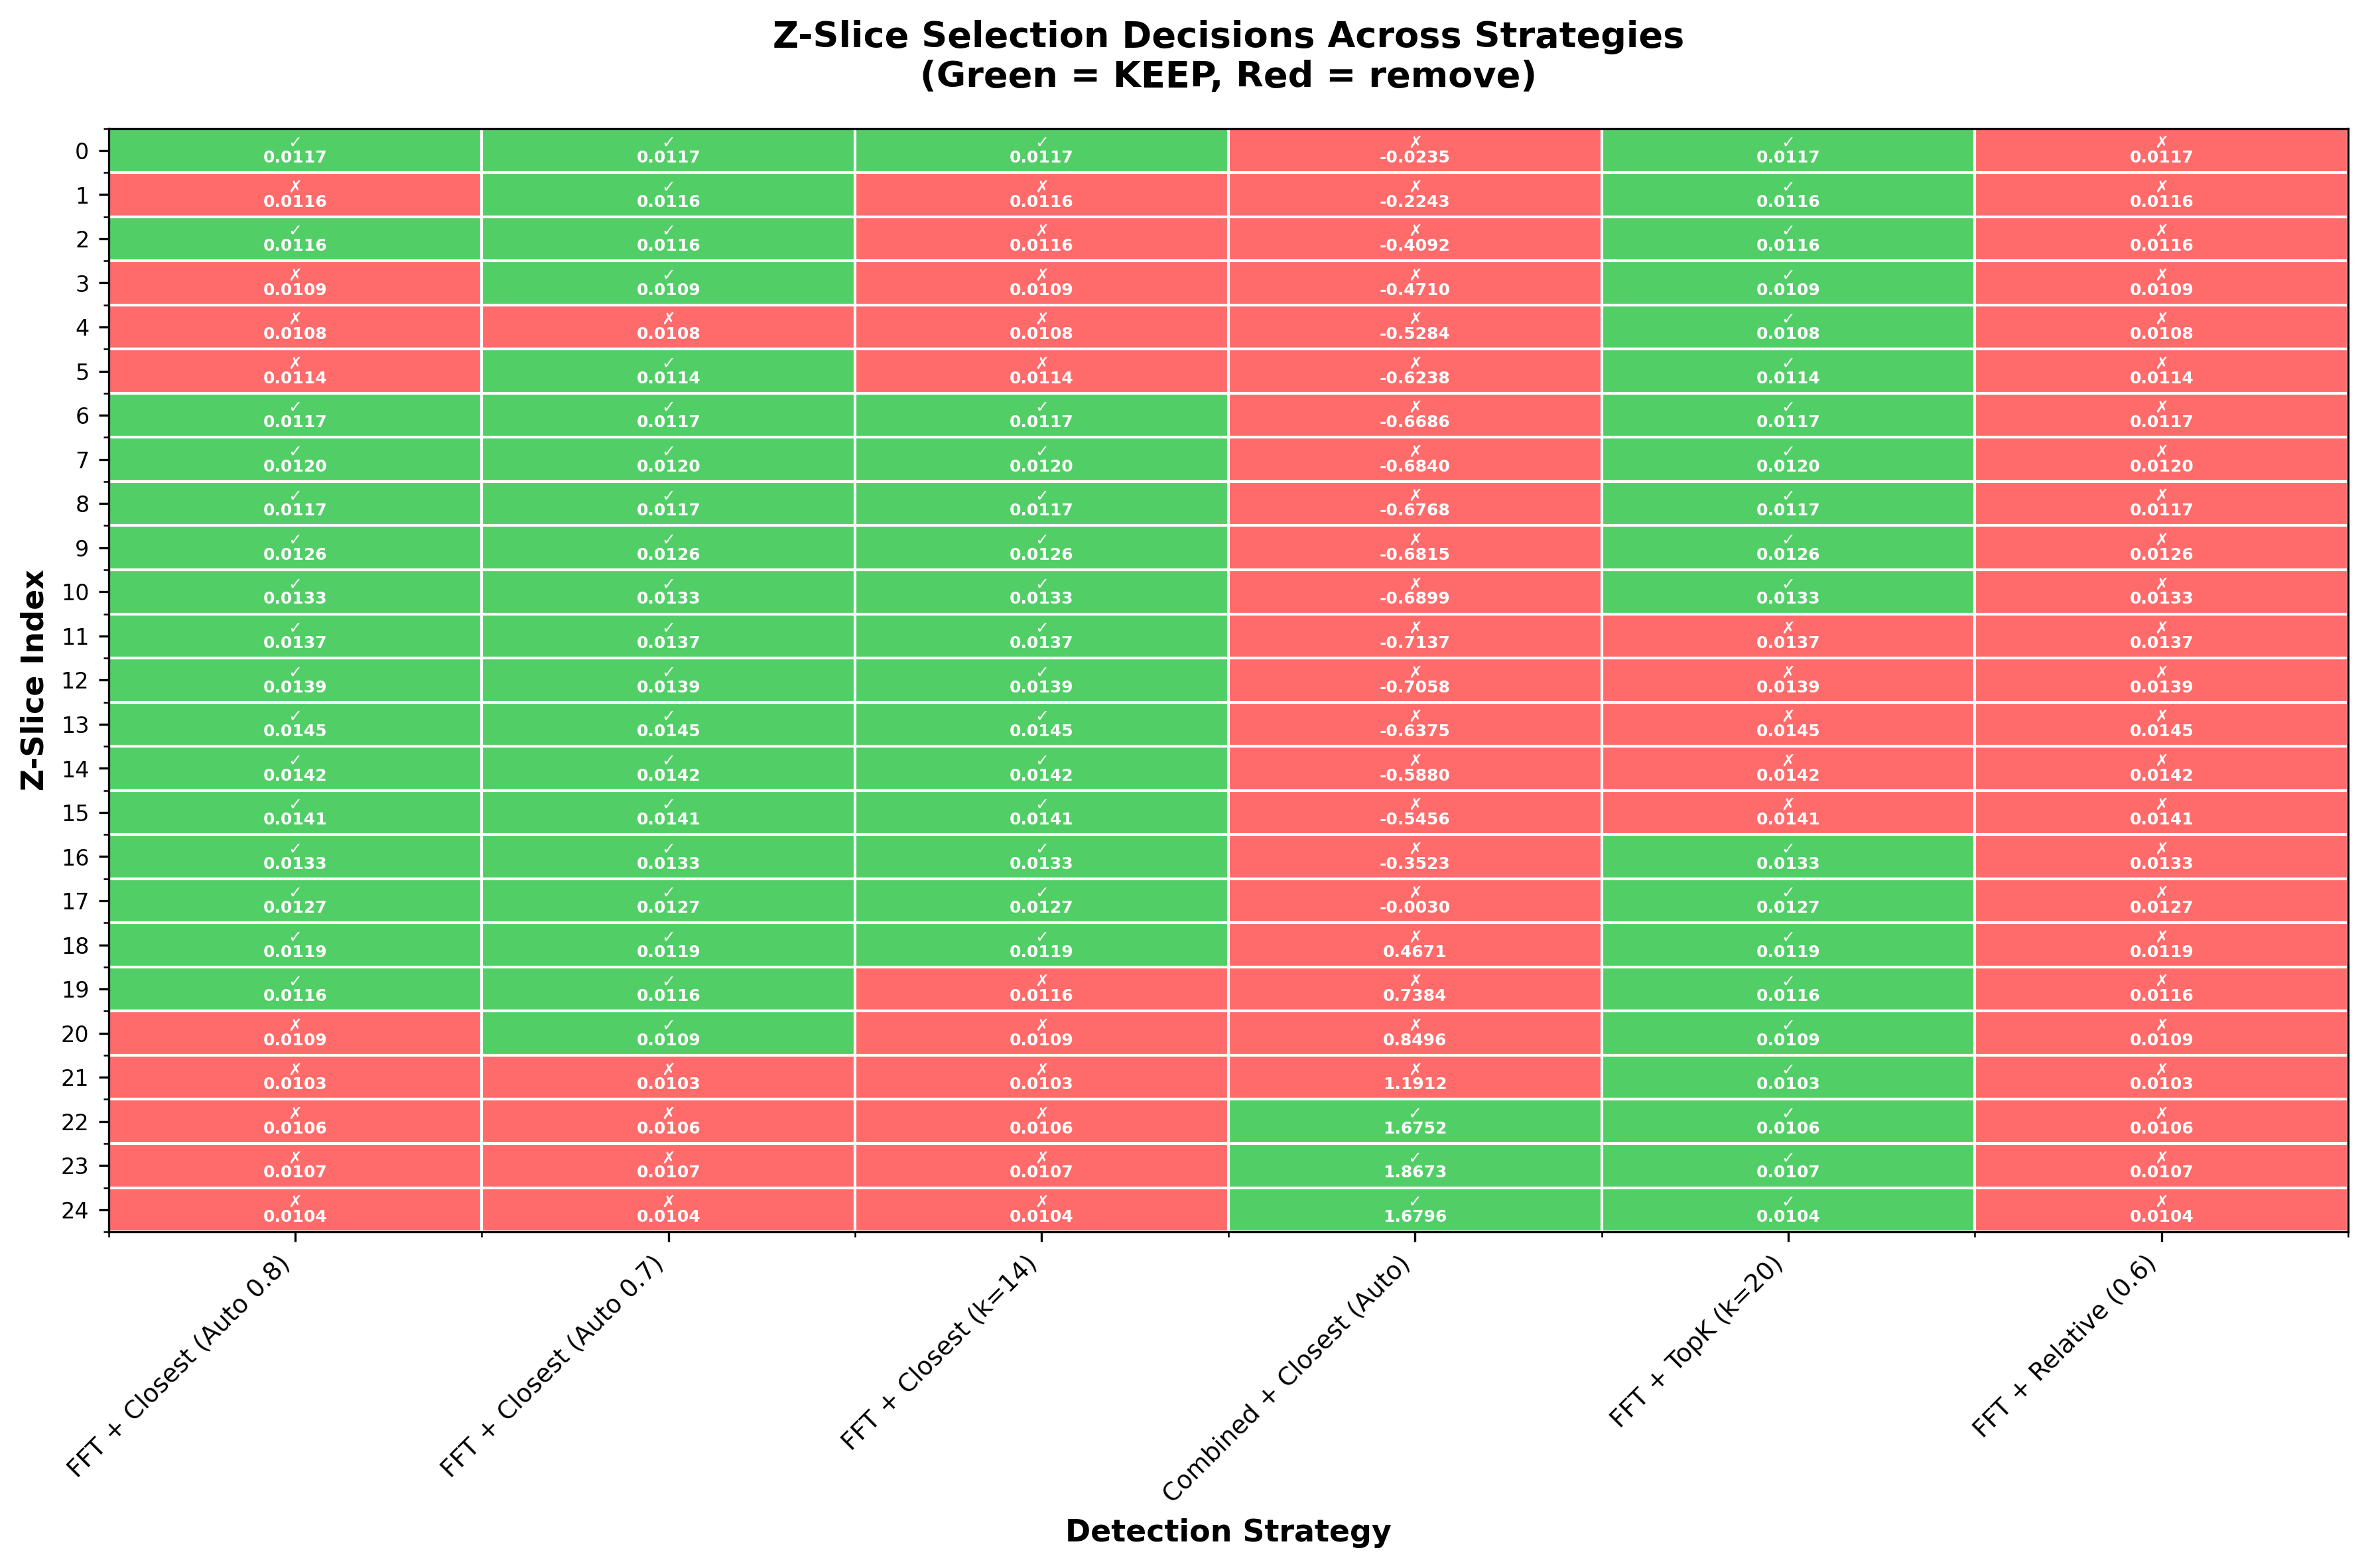

  - Creating slice gallery...
    ✓ Saved: strategy_qc/z_slice_gallery.png


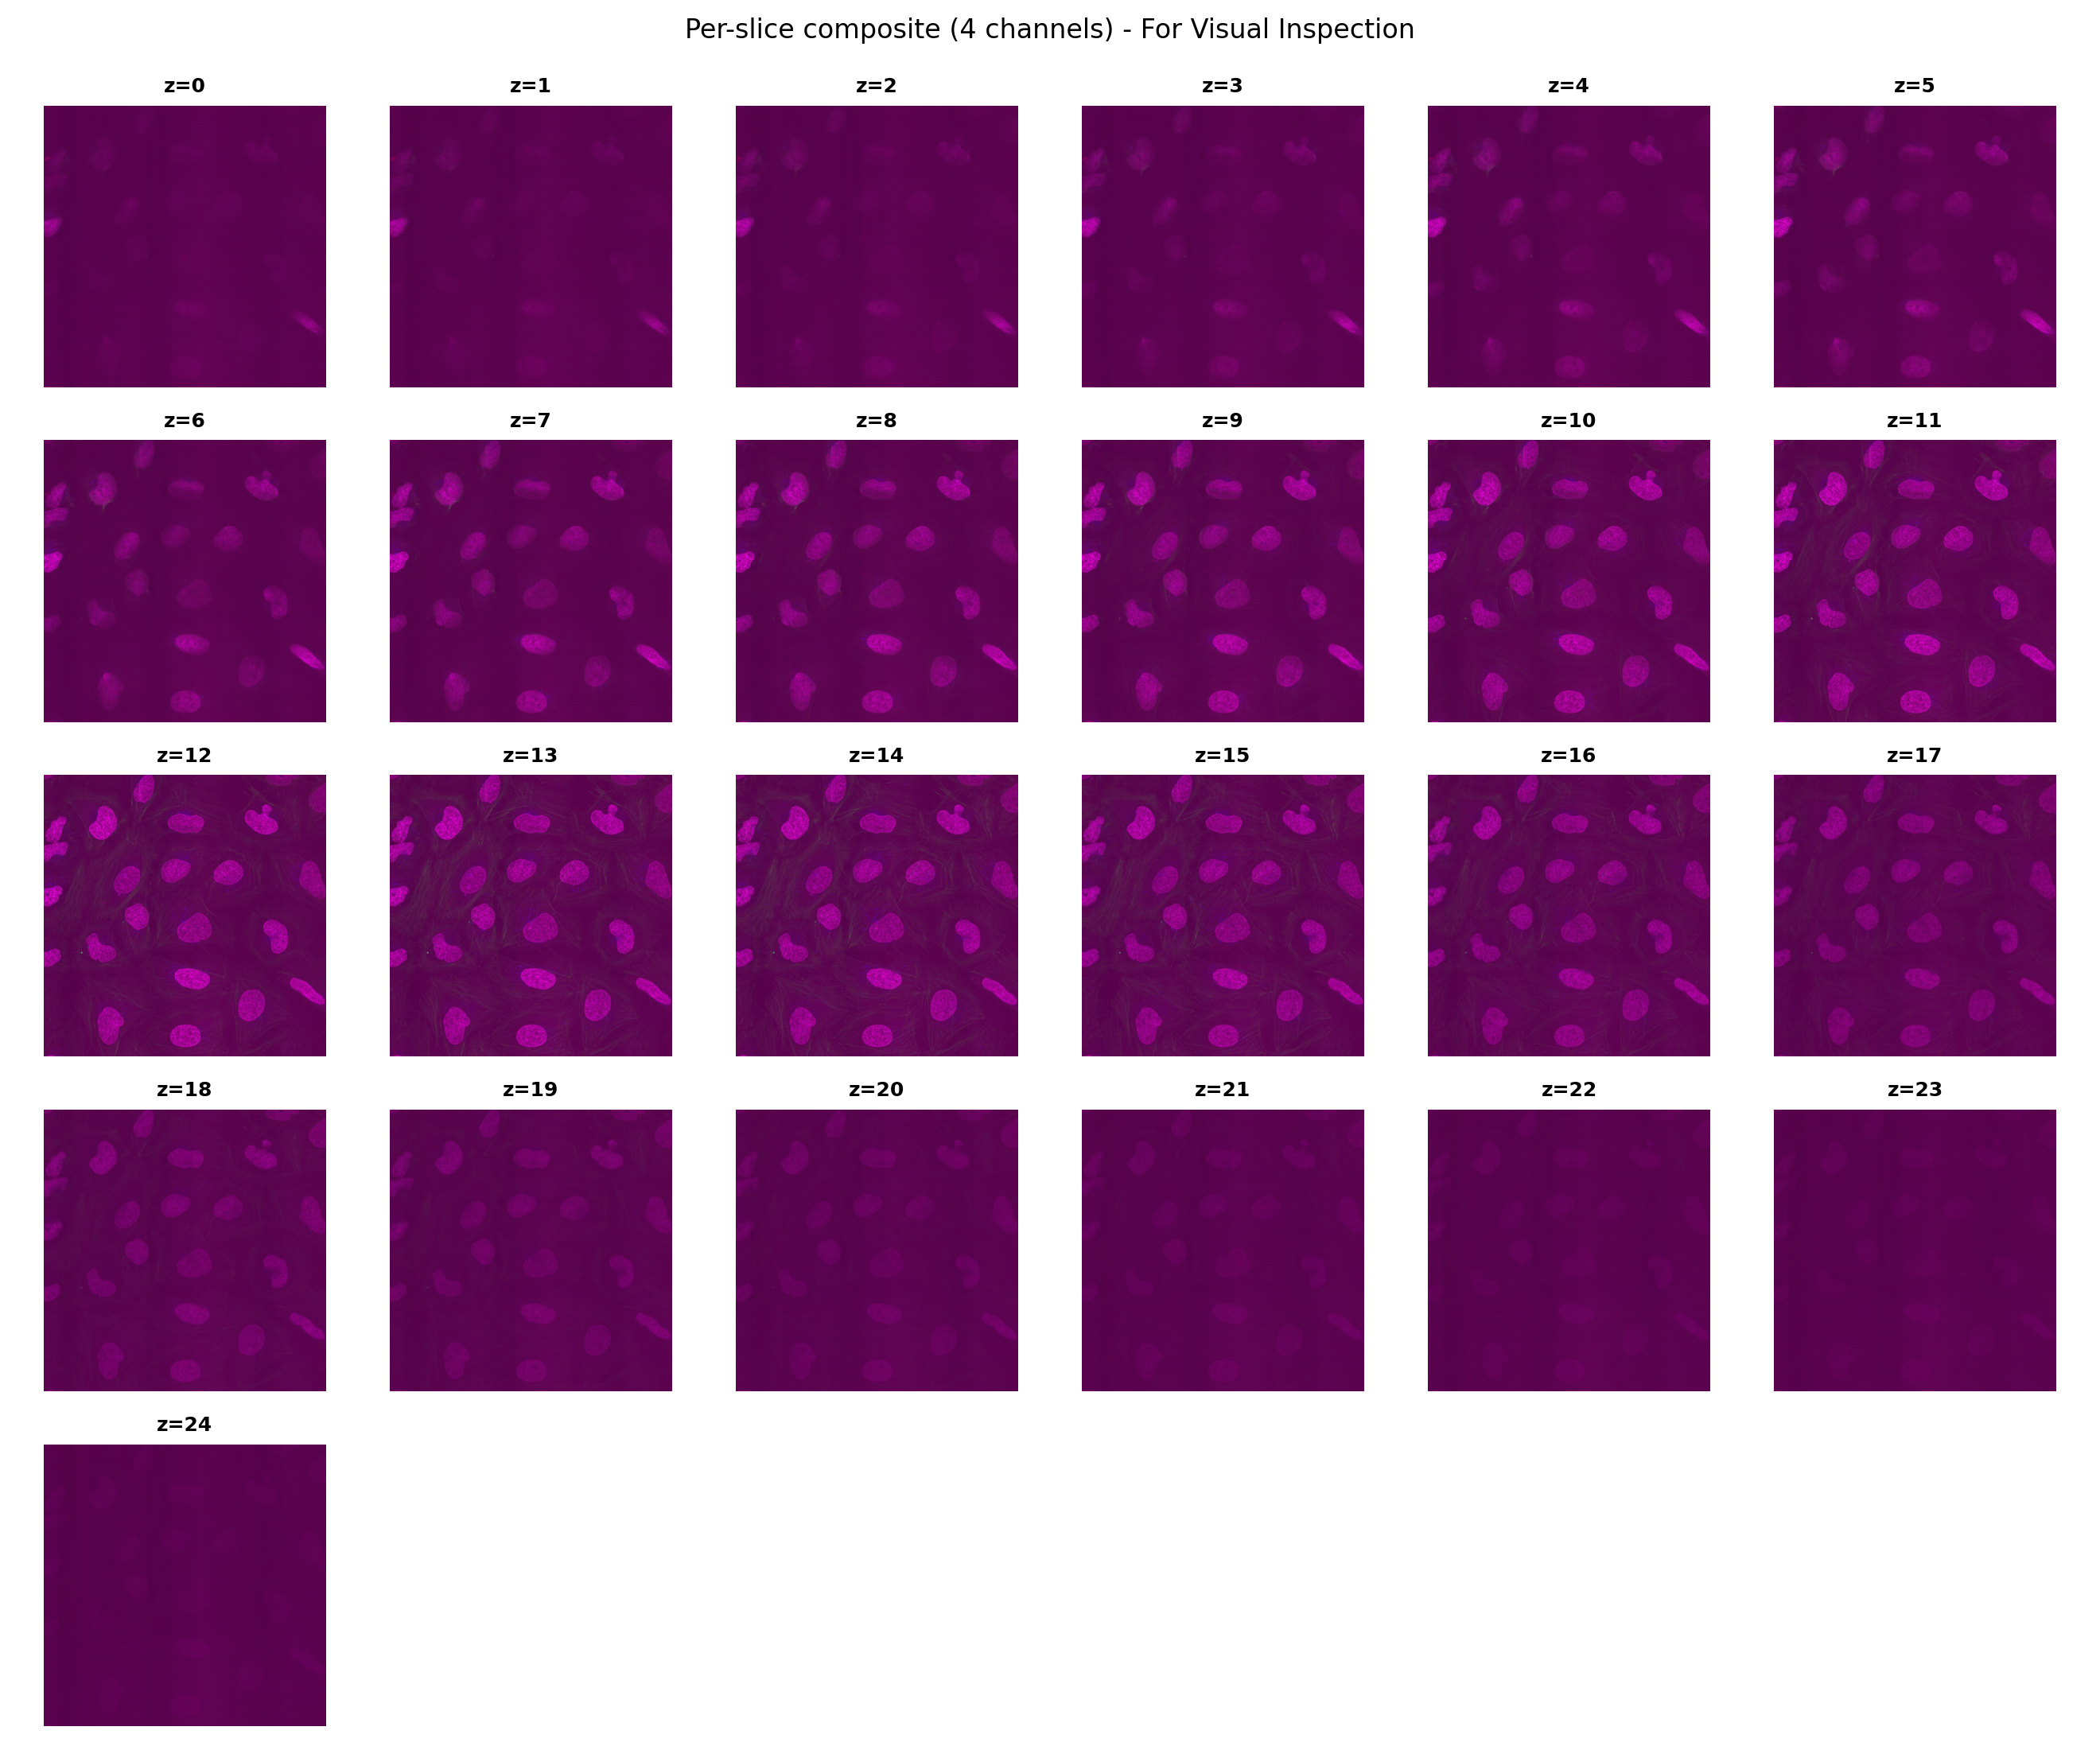

INFO: Comparison complete!


  - Creating strategy summary...
    ✓ Saved: strategy_qc/comparison_summary.txt

Strategy Comparison Summary
Total Z-slices: 25
Strategies compared: 6

Strategy                            Kept       Removed    % Kept    
--------------------------------------------------------------------------------
FFT + Closest (Auto 0.8)            16         9          64.0      %
FFT + Closest (Auto 0.7)            20         5          80.0      %
FFT + Closest (k=14)                14         11         56.0      %
Combined + Closest (Auto)           3          22         12.0      %
FFT + TopK (k=20)                   20         5          80.0      %
FFT + Relative (0.6)                0          25         0.0       %


NameError: name 'result' is not defined

In [6]:
# Z slice selection
comparison = cr.compare_strategies(
    image,                      # (Z, Y, X, C)
    save_plots=True,
    output_path="strategy_qc",   # folder
    compute_quality=False, 
    display_inline=True,
)

In [10]:
# After running the methods you can inspect it with
print(comparison.strategy_names)

# Once you visually checked which methods kept the slices you think make sense; 
# Pick your preferred strategy from the comparison
result = comparison.results["FFT + Closest (k=14)"]  # or whichever strategy you prefer

# Apply the filtering
filtered_image = image[result.indices_keep]
channel_names = loader.get_channel_names()

# Convert to dict format (what puncta prefers)
image_dict = {
    ch: filtered_image[..., i] 
    for i, ch in enumerate(channel_names)
}

('FFT + Closest (Auto 0.8)', 'FFT + Closest (Auto 0.7)', 'FFT + Closest (k=14)', 'Combined + Closest (Auto)', 'FFT + TopK (k=20)', 'FFT + Relative (0.6)')


In [13]:
segmenter = cr.CellSegmenter(
    output_dir=Path("/fs/scratch/PAS2598/duarte63/outputs/cellpose"),
    auto_resize=False,          # use fixed candidates instead of auto
    resize_candidates=[600, 400],
    # optional: tighten flow/cellprob if needed
    # flow_threshold=0.4,
    # cellprob_threshold=0.0,
)

seg = segmenter.segment_from_results(
    results=image_dict,
    channel_a="Phalloidin",     # cell boundary channel
    channel_b="DAPI",           # nuclei
    channel_weights=(1.0, 0.10),# strongly favor Phalloidin to avoid nuclei dominance
    projection="mip",
    output_format="png8",
    save_basename=image_path.stem,
)

print("Mask:", seg.mask_path)
print("Outlines:", seg.outlines_path)
print("Mask shape:", seg.mask_array.shape)

INFO: Creating max projection from shape (14, 1800, 1800, 2)
INFO: Created max projection with shape (1800, 1800, 2)
INFO: HTTP Request: GET https://huggingface.co/api/spaces/mouseland/cellpose "HTTP/1.1 200 OK"
INFO: HTTP Request: GET https://huggingface.co/api/spaces/mouseland/cellpose/runtime "HTTP/1.1 200 OK"


Loaded as API: https://mouseland-cellpose.hf.space ✔


INFO: HTTP Request: GET https://mouseland-cellpose.hf.space/config "HTTP/1.1 200 OK"
INFO: HTTP Request: GET https://mouseland-cellpose.hf.space/gradio_api/info?serialize=False "HTTP/1.1 200 OK"
INFO: Calling /update_button with image /tmp/cellpose_composite.png
INFO: HTTP Request: HEAD https://huggingface.co/api/telemetry/py_client/initiated "HTTP/1.1 200 OK"
INFO: HTTP Request: GET https://mouseland-cellpose.hf.space/gradio_api/heartbeat/82ecc4da-6cd6-4055-b6d2-956b99e0f35c "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://mouseland-cellpose.hf.space/gradio_api/upload "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://mouseland-cellpose.hf.space/gradio_api/queue/join "HTTP/1.1 200 OK"
INFO: HTTP Request: GET https://mouseland-cellpose.hf.space/gradio_api/queue/data?session_hash=82ecc4da-6cd6-4055-b6d2-956b99e0f35c "HTTP/1.1 200 OK"
INFO: HTTP Request: GET https://mouseland-cellpose.hf.space/gradio_api/file=/tmp/gradio/2c5df3df8c6750e818077fb465e99c51cfa22f75175bbf55ddded0deab033332/

Mask: /fs/scratch/PAS2598/duarte63/outputs/cellpose/anti_ALIX_ctrl_3.ome_masks.tif
Outlines: /fs/scratch/PAS2598/duarte63/outputs/cellpose/anti_ALIX_ctrl_3.ome_outlines.png
Mask shape: (1800, 1800)


In [14]:
from colokroll.analysis import compute_puncta

mask_path = Path("/fs/scratch/PAS2598/duarte63/outputs/cellpose/anti_ALIX_ctrl_3.ome_masks.tif")


# After background subtraction (results dict)
puncta_result = compute_puncta(
    image=image_dict,           # dict[channel] -> (Z,Y,X) array
    mask=mask_path,     # labeled cell mask
    channel="ALIX",
    projection="mip",
    pixel_size_um=0.1,
    expected_diameter_um=0.5,
    snr_threshold=3.0,
)

# Access results
for p in puncta_result["results"]["puncta"]:
    print(f"Punctum {p['punctum_id']} in cell {p['cell_label']}: SNR={p['snr']:.1f}")

for c in puncta_result["results"]["per_label"]:
    print(f"Cell {c['cell_label']}: {c['puncta_count']} puncta, density={c['puncta_density_per_um2']:.2f}/µm²")

INFO: Loaded channel 'ALIX' with shape (14, 1800, 1800)
INFO: Projected to 2D: (1800, 1800) (projection='mip')
INFO: Loading TIF mask: /fs/scratch/PAS2598/duarte63/outputs/cellpose/anti_ALIX_ctrl_3.ome_masks.tif
INFO: Mask contains 32 unique values
INFO: Successfully loaded mask with shape: (1800, 1800)
INFO: Removed cell label 1 from mask (assumed Cellpose background)
INFO: Detection params: log_sigma=1.77px, min_distance=5.00px, snr_threshold=3.0, min_area=4px, max_area=628px
INFO: Background estimate: mean=115.00, std=2.97
INFO: Detected 22147 puncta seeds
INFO: After size filtering: 15817 puncta remain
INFO: Measured 15817 puncta
INFO: compute_puncta finished: 15815 puncta in 30 cells


Punctum 1 in cell 15: SNR=12.1
Punctum 2 in cell 15: SNR=8.9
Punctum 3 in cell 8: SNR=9.6
Punctum 4 in cell 15: SNR=7.5
Punctum 5 in cell 15: SNR=10.1
Punctum 6 in cell 24: SNR=11.1
Punctum 7 in cell 13: SNR=12.5
Punctum 8 in cell 13: SNR=9.6
Punctum 9 in cell 21: SNR=7.9
Punctum 10 in cell 15: SNR=6.7
Punctum 11 in cell 31: SNR=10.6
Punctum 12 in cell 24: SNR=6.3
Punctum 13 in cell 18: SNR=9.0
Punctum 14 in cell 23: SNR=7.1
Punctum 15 in cell 2: SNR=7.1
Punctum 16 in cell 20: SNR=7.1
Punctum 17 in cell 19: SNR=6.7
Punctum 18 in cell 20: SNR=7.8
Punctum 19 in cell 15: SNR=11.1
Punctum 20 in cell 15: SNR=8.0
Punctum 21 in cell 24: SNR=6.4
Punctum 22 in cell 15: SNR=8.5
Punctum 23 in cell 2: SNR=6.5
Punctum 24 in cell 9: SNR=11.6
Punctum 25 in cell 16: SNR=6.8
Punctum 26 in cell 12: SNR=6.0
Punctum 27 in cell 29: SNR=9.1
Punctum 28 in cell 26: SNR=6.5
Punctum 29 in cell 16: SNR=7.7
Punctum 30 in cell 11: SNR=7.6
Punctum 31 in cell 21: SNR=6.5
Punctum 32 in cell 25: SNR=5.6
Punctum 33 in 

In [17]:
#from colokroll.analysis.colocalization import compute_colocalization

mask_path = Path("/fs/scratch/PAS2598/duarte63/outputs/cellpose/anti_ALIX_30_min_3.ome_masks.tif")

res = cr.compute_colocalization(
    image=results,
    mask=mask_path,
    channel_a="ALIX",
    channel_b="LAMP1",
    channel_names=channel_names,
    pearson_winsor_clip=0.1,
    thresholding="costes",        # or "costes"/"percentile"/"fixed"/"none"
    min_area="auto",
    min_area_fraction=0.70,
    max_border_fraction=0.10,
    border_margin_px=1,
    drop_label_1=True,
    plot_mask=True,            # set True if you want the kept/removed label plot
)

# Per-cell metrics (one row per kept label)
df_cells = pd.DataFrame(res["results"]["per_label"]).sort_values("label")
# Total-image metrics (single row)
df_total = pd.DataFrame([res["results"]["total_image"]])

# Quick access to key metrics
pearson_total = res["results"]["total_image"]["pearson_r"]
manders_m1_total = res["results"]["total_image"]["manders_m1"]
manders_m2_total = res["results"]["total_image"]["manders_m2"]
jaccard_total = res["results"]["total_image"]["jaccard"]

pearson_total, manders_m1_total, manders_m2_total, jaccard_total

INFO: Loading TIF mask: /fs/scratch/PAS2598/duarte63/outputs/cellpose/anti_ALIX_30_min_3.ome_masks.tif
INFO: Mask contains 28 unique values
INFO: Successfully loaded mask with shape: (1800, 1800)
INFO: Loaded labeled mask with integer dtype: uint16
INFO: Loaded labeled mask with integer dtype: int32
INFO: Estimated min_area threshold: fraction=0.7, median_area=88047 -> thr=61632
INFO: Auto-estimated min_area threshold: 61632 (fraction=0.7)
INFO: Starting compute_colocalization(ch_a=ALIX, ch_b=LAMP1, normalization_scope=none, min_area=61632, max_border_fraction=0.1, border_margin_px=1, plot_mask=True)
INFO: Image loaded: shape=(23, 1800, 1800, 4), channels=['LAMP1', 'Phalloidin', 'ALIX', 'DAPI'] | Mask loaded: shape=(1800, 1800), unique_labels=27
INFO: Manders coefficients (M1/M2) weighting: voxel (thresholding=costes, z-slices=23)
INFO: Filtering labels: min_area=61632, max_border_fraction=0.1, border_margin_px=1 -> kept=22, removed=4
INFO: Prepared mask plot (kept=22, removed=5, show=

(0.35596283726844996,
 0.5055192947727383,
 0.5038739449508228,
 0.3236762303252528)